# GlassAI data

This notebook explores data obtained from GlassAI

I want to understand the data.
* Key variables (to document)
* Questions for them
* Interesting questions we could explore with these data
* Validation vs official data by sector

...



## Preamble

In [56]:
%matplotlib inline
#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim/')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models/')

#Visualisations
viz_path = os.path.join(top,'src/visualization')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [57]:
import string
digits = string.digits

In [58]:
#Utilities
#This function takes a df with levels of activity and creates one with location quotients.

def sum_elements_in_list_of_lists(list_of_lists):
    '''
    Some times we have lists whose elements are lists of lists (eg a tokenised corpus) where we want to 
    extract the distribution.
    This function does that
    '''
    
    out_sorted = pd.Series([x for el in list_of_lists for x in el]).value_counts(ascending=False)
    return(out_sorted)
    

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

## 1. Load data


In [564]:
#Read Glass AI data
#Read and lowercase columns
glai_columns= [x.lower() for x in ['id','name','GeneratedSector','GeneratedSubsector','GeneratedTag',
          'SourceSector','SourceSubsector','Status','PredictedSector','Topics','PostalTowns','Website']]

#Read data
data = pd.read_csv(ext_data+'/org_creative_by_subsectors_v2.txt',sep='\t',header=None)

#Read detailed topic info we were sent
topics = pd.read_csv(ext_data+'/org_creative_topics.txt',sep='\t',header=None)

#Read detailed descriptions we were sent
descs = pd.read_csv(ext_data+'/org_creative_descriptions.txt',sep='\t',header=None)

#Rename data columns
data.columns=glai_columns

In [565]:
#Shape
#Around 253K companies
data.shape

(253650, 12)

In [61]:
#Merge data with descriptions
data2 = pd.merge(data,descs,left_on='id',right_on=0).drop(0,axis=1)

#And rename the description variables
data2.rename(columns={1:'desc_1',2:'desc_2'},inplace=True)

In [62]:
#For each company, gather the topics by id into lists and merge the result with our data
topics_gathered = topics.groupby(1)[0].apply(lambda x: list(x))
data3 = pd.concat([data2.set_index('id'),topics_gathered],1)

data3.rename(columns={0:'topics_detailed'},inplace=True)

In [63]:
#Get value counts for categorical variables (where the total number of values is less than 100).
#NB we remove topics detailed from the count because value counts doesn't work with a list
value_counts = [[x,data3.loc[:,x].value_counts()] for x in data3.columns.drop('topics_detailed') 
                if len(set(data3.loc[:,x]))<100]

#And print them
for x in value_counts:
    print(x[0])
    print('====')
    print(x[1])
    print('\n')


generatedsector
====
Media and Arts                  77180
Technology                      77106
Professional Services           65311
Consumer Goods and Services     21948
Real Estate and Construction    11123
Non Profit and Education          982
Name: generatedsector, dtype: int64


generatedsubsector
====
Information Technology and Services    34025
Marketing and Advertising              30885
Design                                 26894
Internet                               25471
Computer Software                      15369
Apparel and Fashion                    13128
Music                                  12745
Arts and Crafts                        12477
Architecture and Planning              11123
Photography                             9983
Newspapers and Magazines                8892
Luxury Goods and Jewellery              8820
Media Production                        8262
Publishing                              7190
Motion Pictures and Film                5004
Broadcast Medi

Some initial questions:
* What is the difference between sourcesector and generated sector?
* What do U and C mean?

## Initial topic exploration

In [64]:
#Check the topics

#Split them into lists of topics unless they are nan
data3['topics_list'] = [x.split(",") if type(x)==str else [] for x in data3.topics]

#How many companies with missing topics do we have?
np.sum([len(x)==0 for x in data3.topics_list])/len(data3)

0.55052631578947364

We have topics for 55% of the companies in the dataset. 

In [65]:
data3['has_topic'] = [len(x)>0 for x in data3.topics_list]

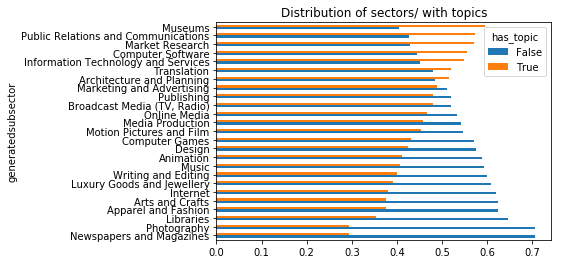

In [66]:
#Plot
pd.crosstab(data3['has_topic'],
            data3['generatedsubsector'],normalize=1).T.sort_values(True).plot.barh(title='Distribution of sectors/ with topics')

In [67]:
#What are the top topics (and by sector)
#This is the total topic count
all_topics_distr = sum_elements_in_list_of_lists(data3.topics_list)

#Glass AI seem to be picking up popular ngrams that companies use to sell stuff.
all_topics_distr[:10]

high quality        1466
social media        1170
long term            532
best possible        483
high profile         476
interior design      473
brand new            457
web design           437
graphic design       430
customer service     422
dtype: int64

In [68]:
#Create a topic as share of all topics variable we can use to normalise inside subsectors (a bit like tfidf)
all_topics_share = pd.DataFrame(all_topics_distr/all_topics_distr.sum())
all_topics_share.columns=['share_all']

In [69]:
#Get top topics by sector
#NB we are normalising by the share of topics in the total to find topics which are more relevant for a sector.

#These are the top keywords by sector.
top_keywords_by_sector = data3.groupby('generatedsubsector')['topics_list'].apply(lambda x: pd.Series(
    [t for el in x for t in el]).value_counts(ascending=False)).reset_index(drop=False)

for x in set(top_keywords_by_sector.generatedsubsector):
    print(x)
    print('='*len(x))
    
    topics_in_sector = top_keywords_by_sector.loc[
        top_keywords_by_sector.generatedsubsector==x,[
            'level_1','topics_list']].set_index('level_1').sort_values('topics_list',ascending=False)[:25]
    
    
    topics_in_sector['share_in_sector'] = topics_in_sector/topics_in_sector.sum()
    
    topics_in_sector_norm = topics_in_sector.join(all_topics_share)
    
    topics_in_sector_norm['share_norm'] = topics_in_sector_norm['share_in_sector']/topics_in_sector_norm['share_all']
    
    print(topics_in_sector_norm.sort_values('share_norm',ascending=False)[:10])
    
    print('\n')

Translation
                           topics_list  share_in_sector  share_all  \
level_1                                                              
certified translation               12         0.025424   0.000020   
reliable translation                12         0.025424   0.000020   
professional translators            13         0.027542   0.000022   
language service provider           16         0.033898   0.000026   
translation solutions               10         0.021186   0.000017   
interpreting services               20         0.042373   0.000033   
quality translation                 37         0.078390   0.000063   
professional translation            29         0.061441   0.000050   
translation projects                18         0.038136   0.000031   
translation company                 17         0.036017   0.000030   

                            share_norm  
level_1                                 
certified translation      1280.760593  
reliable translation    

In [70]:
# Have a look at the detailed topics
#Extracting the info.
det_top_distr = sum_elements_in_list_of_lists(data3.topics_detailed.dropna())

In [71]:
#What's their distribution?
print(len(det_top_distr))
print(det_top_distr.describe())

print(det_top_distr.sum())

6189570
count    6.189570e+06
mean     4.023699e+00
std      2.179109e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      2.130700e+04
dtype: float64
24904966


We have 6m unique topics appearing a total of 24m times... How can we use them?

In [72]:
#How many are there per company? Could we use these data to do some topic modelling / other types of NLP?

comp_topic_n = pd.Series([len(x) for x in data3.topics_detailed.dropna()])

comp_topic_n.describe()

#Ok so this is quite rich. We could do something with it.


count    168199.000000
mean        148.068574
std         947.679107
min           1.000000
25%           8.000000
50%          19.000000
75%          59.000000
max      112320.000000
dtype: float64

## Postal cities

In [73]:
#What about the 'postal cities'?
#For how many do we have data?

#We only have addresses for ~ half of the data
np.sum(data3.postaltowns.isnull())/len(data3)

0.50386359156317762

In [74]:
#Create list of postaltowns

data3['towns_list'] = [[t.lower() for t in x.split(',')] if type(x)==str else [] for x in data3.postaltowns]

print(pd.Series([len(x) for x in data3['towns_list']]).describe())

count    253650.000000
mean          3.902168
std         157.204638
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       43592.000000
dtype: float64


In [75]:
#There are a few companies with LOTS of addresses

data3.loc[[len(x)>500 for x in data3['towns_list']],:][:10]

,name,generatedsector,generatedsubsector,generatedtag,sourcesector,sourcesubsector,status,predictedsector,topics,postaltowns,website,desc_1,desc_2,topics_detailed,topics_list,has_topic,towns_list
375,1st Directory,Professional Services,Marketing and Advertising,R2,Professional Services,Information Services,U,Non Profit and Education:Charities and Foundat...,"united kingdom,directory listings,real world","600 096,AB10 1AQ,AB10 1AR,AB10 1TN,AB10 1XE,AB...",1stdirectory.co.uk,QualitySolicitors D'Angibau - Bournemouth are ...,Directories are the basic building blocks of c...,"[abrasive waterjet cutting, a conversation, ac...","[united kingdom, directory listings, real world]",True,"[600 096, ab10 1aq, ab10 1ar, ab10 1tn, ab10 1..."
1417,5pm.co.uk,Technology,Internet,R1,Technology,Internet,U,"Technology:Internet:37.1080395934,Leisure and ...",NaN,"AB10 1JN,AB10 1NN,AB10 1SU,AB10 1TX,AB10 6PY,A...",www.5pm.co.uk,"Browse menus, read reviews and pick offers.",For restaurateurs 5pm offer the opportunity to...,"[aa rosette, beauty outlets, best deals, black...",[],False,"[ab10 1jn, ab10 1nn, ab10 1su, ab10 1tx, ab10 ..."
1626,96.4 Eagle Radio,Media and Arts,"Broadcast Media (TV, Radio)",R1,Media and Arts,"Broadcast Media (TV, Radio)",U,Non Profit and Education:Charities and Foundat...,"west surrey,rock songs,brain tumour,classic po...","BN21 4TX,BN27 4AB,CR0 1DN,CR8 2EF,EC2A 2EW,GU1...",www.964eagle.co.uk,Eagle Radio is the number one radio station in...,Eagle Radio (formerly 96.4 The Eagle) is a loc...,"[absolute mile, absolute outrage, accident inv...","[west surrey, rock songs, brain tumour, classi...",True,"[bn21 4tx, bn27 4ab, cr0 1dn, cr8 2ef, ec2a 2e..."
6247,Adzuna,Technology,Internet,R1,Technology,Internet,U,Professional Services:Staffing and Recruiting:...,"car ads,vertical search","AB10 1JX,AB11 7XH,AB22 8AL,AL3 8HZ,AL4 9RH,AL5...",www.adzuna.co.uk,Adzuna is a search engine for job advertisemen...,Adzuna is a search engine for job advertisemen...,"[account management, account manager, ads site...","[car ads, vertical search]",True,"[ab10 1jx, ab11 7xh, ab22 8al, al3 8hz, al4 9r..."
11450,Amee,Technology,Internet,R2,Energy and Environmental,Renewables and Sustainability,U,Professional Services:Information Services:25....,"waste generation,information provider,carbon e...","AB10 1FW,AB10 1QR,AB11 5NS,AB21 0DP,AB21 7HG,A...",www.amee.com,AMEE’s mission is to empower businesses to be ...,Avoiding Mass Extinctions Engine (abbreviated ...,"[accidental loss, accounting methodologies, ai...","[waste generation, information provider, carbo...",True,"[ab10 1fw, ab10 1qr, ab11 5ns, ab21 0dp, ab21 ..."
14461,Approved Index,Technology,Internet,R1,Technology,Internet,U,"Technology:Internet:28.0412671731,Professional...","valid email,time effective,enquiry form,servic...","AB10 1FW,AB10 1JG,AB15 4ZT,AB25 3TZ,AB34 5HE,A...",www.approvedindex.co.uk,Appletree Print's listing in the Approved Inde...,At Approved Index our unique tailored service ...,"[acceptable air quality, ad credits, additiona...","[valid email, time effective, enquiry form, se...",True,"[ab10 1fw, ab10 1jg, ab15 4zt, ab25 3tz, ab34 ..."
19790,Auto Trader,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Supply Chain and Transport:Automotive:64.45716...,"digital brands,automotive sector,car ownership...","AB12 3JG,AB21 9US,AB23 8JW,AB31 4HE,AB51 5RB,A...",www.autotrader.co.uk,Our make a difference strategy extends to ensu...,Auto Trader Group plc is an automotive classif...,"[acceleration times, accountancy profession, a...","[digital brands, automotive sector, car owners...",True,"[ab12 3jg, ab21 9us, ab23 8jw, ab31 4he, ab51 ..."
23259,The Bath Chronicle,Media and Arts,Newspapers and Magazines,R1,Media and Arts,Newspapers and Magazines,U,Media and Arts:Newspapers and Magazines:50.812...,"bath rugby,central library,safety group,video ...","B74 2PG,B79 7UL,BA1 0AB,BA1 1AA,BA1 1AN,BA1 1B...",www.bathchronicle.co.uk,The Bath Chronicle is a wee

This seems to be picking up losts of directories / newspapapers / online sites for mapping (?)

In [76]:
#What are the most popular towns?

pd.Series([x for el in data3['towns_list'] for x in el]).value_counts(ascending=False)[:10]

ip14 1dt    3476
ec1v 2nx     410
ec2a 4ne     386
n1 7gu       386
w14 8ux      290
wc2h 9jq     284
w1b 3hh      275
e1 6ql       246
ec1v 4pw     244
e16 1xl      242
dtype: int64

In [77]:
data3.columns

Index(['name', 'generatedsector', 'generatedsubsector', 'generatedtag',
       'sourcesector', 'sourcesubsector', 'status', 'predictedsector',
       'topics', 'postaltowns', 'website', 'desc_1', 'desc_2',
       'topics_detailed', 'topics_list', 'has_topic', 'towns_list'],
      dtype='object')

In [30]:
#Rename columns
data3.columns = ['name','creative_glai_sector','creative_glai_subsector','source',
                'source_glai_sector','source_glai_subsector','status','sector_probabilities','topics_short','postcodes',
               'website','topics_list','description_1','description_2','long_topics','has_topics','postcode_list']

#Drop irrelevant columns3
glass_ai = data3.drop(['status','topics_short','postcodes','has_topics'],axis=1)

In [27]:
del data2, data3, topics

In [31]:
glass_ai.rename(columns={'description2':'description_2'},inplace=True)

In [34]:
#Output for Cath
glass_ai.reset_index(drop=False).to_json(int_data+'/{date}_glai_companies.json'.format(date=today_str),orient='records')

In [582]:
check_ids = [139, 268, 413, 2714518, 2714660, 2715063]

[x in glass_ai.reset_index(drop=False)['index'] for x in check_ids]



[True, True, True, False, False, False]

In [575]:
#ARGH

#for x in glass_ai.columns:
#    print(x+" ("+
#          re.sub("\'","",re.sub(">",")",
#                 re.sub("<","(",str(type(glass_ai.loc[:,x].iloc[0])))).split(" ")[1]+":"))
#    print("\n")

## 2. Explore and enrich data

* Rename and document data
* Decide what to do about companies with mixed sectors
* Obtain postcodes and assign companies to a single location
* Develop a protocol to assign companies to sectors and validate vs official data
 * Use the lookup. Challenge = There are a couple of sectors with more than one 

In [78]:
#Load metadata for all this enrichment

#Load NSPL data
nspl = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK/Data/NSPL_AUG_2017_UK.csv',
                   usecols=['pcds','ttwa','laua','gor']
                  )
#Load TTWA labels
ttwa_labels = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK/Documents/TTWA names and codes UK as at 12_11 v5.txt',
                          delimiter='\t')
#Tidy labels
ttwa_labels.rename(columns={'TTWA11CD':'ttwa_code','TTWA11NM':'ttwa_name'},inplace=True)


#Load the GlassAI - DCMS lookup and lowercase columns
glai_dcms_lookup = pd.read_excel(ext_data+'/glass_ai_dcms_lookup.xlsx',sheetname=1)
glai_dcms_lookup.columns = [x.lower() for x in glai_dcms_lookup.columns]

glai_dcms_lookup.rename(columns={'creative_sector':'dcms_sector'},inplace=True)


/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [186]:
#We want to create a dict looking up subsectors vs dcms
#First focus on the subsectors linked to dcms sectors
glai_dcms_lookup_subset = glai_dcms_lookup.dropna(axis=0,subset=['dcms_sector'])

#This is a dict with keys = glai subsector labels and values = dcms sectors
glai_subsector_dcms_lookup = {x:y for x,y in zip(glai_dcms_lookup_subset.subsector,
                                                 glai_dcms_lookup_subset.dcms_sector)}

#This is a list of all the glai labels associated to a creative subsector
glai_creative_subsector_labels = list(glai_subsector_dcms_lookup.keys())

In [79]:
#Drop companies with lots of postcodes
postcodes_n = pd.Series([len(x) for x in glass_ai.postcode_list])

postcodes_n.value_counts()/len(postcodes_n)

#If we drop all companies with more than 5 postcodes this amounts to 4% of the data.

100*np.sum(postcodes_n>5)/len(postcodes_n)

#Subset the data to focus on companies with few addresses, and identify the top address
#NB need to reindex
glass_ai_sub = glass_ai.reset_index(drop=False)[postcodes_n<=5]

#Here is the top address
glass_ai_sub['postcode_top'] = [x[0].strip() if len(x)>0 else np.nan for x in glass_ai_sub.postcode_list]

#Merge with nspl
nspl['pcds']=[x.lower() for x in nspl['pcds']]

In [80]:
#There is a small number of missing postcodes from the NSPL data
#Some of them seem postboxes
missing_postcodes = set(glass_ai_sub['postcode_top'].dropna()) - set(nspl['pcds'])

np.sum([x[0] in digits for x in missing_postcodes])

261

In [82]:
#Let's work with these
#Merge
glass_ai_sub = pd.merge(pd.merge(glass_ai_sub,nspl,left_on='postcode_top',right_on='pcds',how='left'),
                       ttwa_labels,left_on='ttwa',right_on='ttwa_code')
                       
#Now get the sectors
glai_labelled = pd.merge(glass_ai_sub,
                        glai_dcms_lookup,left_on='creative_glai_subsector',right_on='subsector')

#This variable captures if the glass ai subsector was a creative subsector
glai_labelled['has_top_subsector'] = [x==y for x,y in zip(glai_labelled.creative_glai_subsector,
                                                          glai_labelled.source_glai_subsector)]

In [83]:
glai_labelled.drop('observation',axis=1,inplace=True)

Now we want to explore different ways to define a creative sector

* We can use GlassAI's strategy or we can find what's the top sector and probability for each company and create some rules (ie if the top sector is creative and with a probability above a certain threshold...)

In [175]:
#We neeed to create an alternative sector probabilities variable removing commas (commas also used to separate
#sectors in the sector probability variable)

glai_labelled['sector_probs_clean'] = [re.sub(", "," " ,x) 
                                    if type(x)==str else np.nan for x in glai_labelled.sector_probabilities]

#GLAI probabilities is a list where every element is a list of subsectors and probabilities
glai_probabilities = [
    [[el.split(':')[1],float(el.split(':')[2])] for el in x.split(",")] 
    if type(x)==str else np.nan for x in glai_labelled['sector_probs_clean']]


In [507]:
#What are the categories I want to analyse?

#First creative sector (with a prob threshold)

def get_first_creative_sector(prob_vector,thres=30):
    '''
    This function goes through a vector of sector probabilities and returns a creative sector if it is the first one
    and above a certain probability threshold
    '''
    
    #If the vector of probabilities isn't a missing value...
    if type(prob_vector)==float:
        return(np.nan)
    else:
        most_prob = sorted(prob_vector,key=lambda x:x[1],reverse=True)[0]
        if most_prob[0] in glai_creative_subsector_labels and most_prob[1]>thres:
            return(glai_subsector_dcms_lookup[most_prob[0]])
        else:
            return(np.nan)
    
#Other creative sectors (with a probability threshold)


def get_top_creative_sector(prob_vector,thres=10):
    '''
    This function goes through a vector of sector probabilities and returns the top creative sector if it is
    above a threshold
    '''
    
    #If the vector of probabilities is a missing value then we get a missing value
    if type(prob_vector)==float:
        return(np.nan)
    else:
        #Sort the creative subsectors present here
        most_prob_creative = sorted([x for x in prob_vector if x[0] in glai_creative_subsector_labels],
                                  key = lambda x:x[1],reverse=True)
        
        #If there were no creative subsectors in the topic mix
        if len(most_prob_creative)==0:
            
            return(np.nan)
        
        else:
        #If there were some creative subsectors but the probability of the top one was below the threshold...
        
            if most_prob_creative[0][1]<thres:
                
                return(np.nan)
            
            else:
                return(glai_subsector_dcms_lookup[most_prob_creative[0][0]])
            

In [561]:
#Now we create two variables capturing if a company is the top cr

glai_labelled['creative_sector_first'] = pd.Series([get_first_creative_sector(x,20) for x in glai_probabilities])

glai_labelled['creative_sector_top']= creative_sector_is_present = pd.Series([get_top_creative_sector(x,10) for x in glai_probabilities])


#And finally we create a variable that captures what's the top creative sector ONLY if this isn't the first.
#It's almost like a creative economy measure
glai_labelled['creative_sector_not_first'] = [y if type(x)==float else np.nan for x,y in
                                             zip(glai_labelled.creative_sector_first,
                                                 glai_labelled.creative_sector_top)]


Now we have a couple of variables we can use for comparisons with the official IDBR data.

Next stages:

* Compare creative GLAI LQ vs non creative 
* Produce some descriptive stats

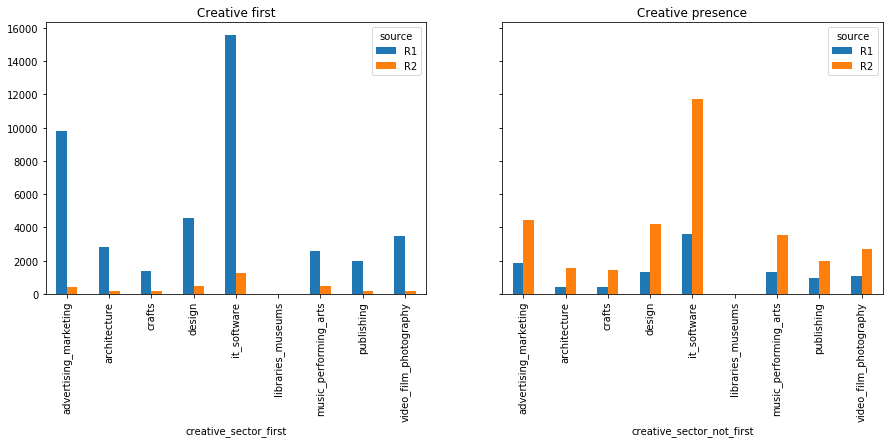

In [562]:
#First 

fig,ax = plt.subplots(ncols=2,figsize=(15,5),sharey=True)


pd.crosstab(glai_labelled.creative_sector_first,glai_labelled.source).plot.bar(
    stacked=False,ax=ax[0],title='Creative first')
pd.crosstab(glai_labelled.creative_sector_not_first,glai_labelled.source).plot.bar(
    stacked=False,ax=ax[1],title='Creative presence')

#Unsurprisingly, most creative companies are picked up by the R1 source, while
#creative economy businesses are picked up by R2


In [563]:
#What do we have in total?
#Creative sector first
creative_sector_first = glai_labelled.creative_sector_first.value_counts()

print(creative_sector_first)

print('')
print(creative_sector_first.sum())

print('')

creative_sector_present = glai_labelled.creative_sector_not_first.value_counts()

print('')

print(creative_sector_present)

print('')
print(creative_sector_present.sum())

it_software               16806
advertising_marketing     10175
design                     5063
video_film_photography     3686
music_performing_arts      3118
architecture               2982
publishing                 2141
crafts                     1598
libraries_museums             7
Name: creative_sector_first, dtype: int64

45576


it_software               15377
advertising_marketing      6318
design                     5526
music_performing_arts      4877
video_film_photography     3823
publishing                 2996
architecture               1994
crafts                     1868
libraries_museums            23
Name: creative_sector_not_first, dtype: int64

42802


So we end with around 90K companies

In [511]:
def extract_companies_in_sector(sector,variable,n=5):
    '''
    Extracts some companies from a sector for visual inspection
    
    '''
    #Select the sector in the variable
    out = glai_labelled.loc[glai_labelled[variable]==sector,:].reset_index(drop=False)
    
    #print(out)
    indices_to_extract = np.random.randint(0,len(out),size=n)
    
    return(out.loc[indices_to_extract,['name','topics_list','long_topics','description_1','description_2']])
    
    

In [512]:
design_comps = extract_companies_in_sector('advertising_marketing','creative_sector_not_first',n=10)

In [513]:
design_comps

,name,topics_list,long_topics,description_1,description_2
8007,Sketch Events,We are Sketch: the experiential and pr stunt e...,[brand ambassadors],We are Sketch: the experiential and PR stunt e...,"[actual chocolate, actual eclipse, adrenaline-..."
428,BluZinc,"Career opportunity in Durban, South Africa for...","[outstanding career, breakfast meeting]",BluZinc candidate attraction provides permanen...,"[admired brands, advert copy, advertised compe..."
5461,GLOBE LOCAL,NaN,[],Globe Local Electronics has designed a ‘Five P...,[best customer service possible]
3345,Montenegro Prospects,Montenegro Prospects is the most experienced I...,"[dance festival, year residency, property buye...","Please note that each holiday lasts two days, ...","[accession talks, actual area, administrative ..."
7843,Ace Communications,NaN,[],NaN,NaN
868,Wait And Read,NaN,[],NaN,NaN
4175,Supermarket,"Supermarket.co.uk was founded in 1996, back wh...","[greater incentive, food prices, financial bur...","Supermarket.co.uk was founded in 1996, back wh...","[afternoon trading, annual sales increase, ave..."
6006,HOWSE ASSOCIATES,NaN,[property related],We pride ourselves on providing our clients wi...,"[best possible service, chartered surveyor, co..."
6703,Business Network,NaN,[business person],We have been operating our unique Business Net...,"[business network, comfortable business, great..."
1395,GERMAN YWCA,NaN,[visitor attractions],NaN,[free visitor attractions]


## Some benchmarking

In [514]:
#Sector totals (all observations)
glass_ai_sector_totals = glai_labelled.dcms_sector.value_counts()
glass_ai_sector_totals.name = 'glass_ai_creative_all'

#Sector totals (high q observations)
glass_ai_sector_totals_high_q = glai_labelled.loc[glai_labelled.source=='R1','dcms_sector'].value_counts()
glass_ai_sector_totals_high_q.name = 'glass_ai_creative_r1'

#sector totals (perfect matches)
glass_ai_sector_totals_perf_match = glai_labelled.loc[
    glai_labelled.has_top_subsector==True,'dcms_sector'].value_counts()

glass_ai_sector_totals_perf_match.name = 'glass_ai_creative_top_match'

#Sector (totals based on first matches and high prob thresholds)
glai_creative_industries_first_totals = creative_sector_first
glai_creative_industries_first_totals.name= 'glass_ai_creative_top_high'

#Creative economy (totals based on top matches and high prob thresholds)
glai_creative_industries_present_totals = creative_sector_present
glai_creative_industries_present_totals.name= 'glass_ai_creative_present_high'

In [515]:
#Let's do a comparison with the IDBR data

#First, create a name lookup so we can merge easily

dcms_names_lookup = {
    'IT, software and computer services':'it_software',
    'Music, performing and visual arts':'music_performing_arts',
    'Film, TV, video, radio and photography':'video_film_photography',
    'Advertising and marketing':'advertising_marketing',
    'Design':'design',
    'Architecture':'architecture',
    'Publishing':'publishing',
    'Museums, galleries and libraries':'libraries_museums',
    'Crafts':'crafts',
    'not_in_sector':'not_in_sector',
    'creative_industries':'creative_industries'}



In [516]:
#Load totals
off_stats =pd.read_csv(ext_data+'/26_11_2017_processed_data.csv')


idbr_totals = off_stats[['sector','bc_2016','ttwa_name','ttwa_code']]

In [517]:
#Extract totals (with clean mname)
idbr_totals['sector_clean'] = [dcms_names_lookup[x] for x in idbr_totals.sector]
idbr_totals.set_index('sector_clean',inplace=True)
#idbr_totals_2016 = idbr_totals.loc[
#    idbr_totals.year==2016,:].groupby('sector_clean')['value'].sum().sort_values(ascending=False)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [518]:
idbr_glass_ai = pd.concat([idbr_totals.reset_index(drop=False).groupby(
    'sector_clean')['bc_2016'].sum(),
                           glass_ai_sector_totals,glass_ai_sector_totals_high_q,
                           glai_creative_industries_first_totals,glai_creative_industries_present_totals,
                          glass_ai_sector_totals_perf_match],axis=1)

idbr_glass_ai['glass_ai_coverage_all'] = idbr_glass_ai['glass_ai_creative_all']/idbr_glass_ai['bc_2016']
idbr_glass_ai['glass_ai_coverage_r1'] = idbr_glass_ai['glass_ai_creative_r1']/idbr_glass_ai['bc_2016']
idbr_glass_ai['glass_ai_coverage_p'] = idbr_glass_ai['glass_ai_creative_top_match']/idbr_glass_ai['bc_2016']
idbr_glass_ai['glass_ai_coverage_first'] = idbr_glass_ai['glass_ai_creative_top_match']/idbr_glass_ai['bc_2016']
idbr_glass_ai['glass_ai_r1_ratio'] = idbr_glass_ai['glass_ai_creative_r1']/idbr_glass_ai['glass_ai_creative_all']

idbr_glass_ai.dropna(inplace=True)

Text(0,0.5,'Glass AI ranking (current)')

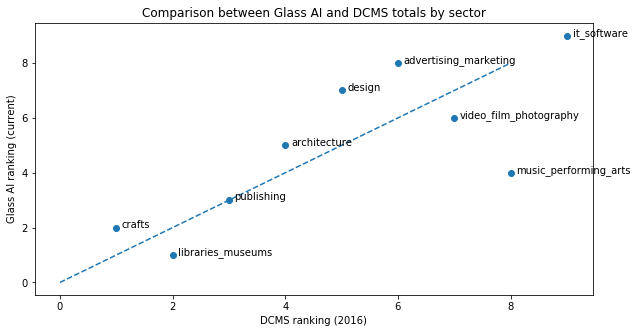

In [519]:
#Visualise differences in rankings

fig,ax = plt.subplots(figsize=(10,5))

#This is giving us the rank of each sector in each dataset
data_ranked = [idbr_glass_ai[x].rank() for x in ['bc_2016','glass_ai_creative_top_high']]

#This list contains sector names for plotting
var_names = idbr_glass_ai.index

#Create scatter
ax.scatter(data_ranked[0],data_ranked[1])


#Add text labels to points
for num,val in enumerate(np.arange(len(var_names))):
    ax.annotate(var_names[num],(data_ranked[0][num]+0.1,data_ranked[1][num]))

#Add a 1-1 line
ax.plot(np.arange(len(var_names)),np.arange(len(var_names)),linestyle='dashed')
    
#Add titles
ax.set_title('Comparison between Glass AI and DCMS totals by sector')
ax.set_xlabel('DCMS ranking (2016)')
ax.set_ylabel('Glass AI ranking (current)')


Glass AI data seems to have better coverage of B2B businesses like advertising and design

In [520]:
#In order to create the LQs for Glass AI we need to capture activity in all other sectors

glass_all = pd.read_csv(ext_data+'/org_non_creative_ttwa.txt',delimiter='\t',header=None)
glass_all.columns = ['ttwa_code','glass_sector','glass_subsector','business_count']

print(glass_all.business_count.sum())

#Create totals. Oddly, the totals are quite small

#We create a list of non-creative sectors by TTWA and label to concatenate along rows.
glass_ttwa_totals = glass_all.groupby('ttwa_code')['business_count'].sum().reset_index(drop=False)
glass_ttwa_totals['sector']='non_creative'




276508


In [521]:
#Create a couple of validation functions
def generate_spec_lq(df,filter_variable=None,filter_value=None,spec_name='unfiltered_lq'):
    '''
    This function generates a specialisation DF based on different filters 
    #(we use those with Glass AI data to validate vs IDBR)
    '''
    
    if filter_variable!=None:
        df = df.loc[df[filter_variable]==filter_value,:]
    
    #Group
    df_grouped = df.groupby(
            ['ttwa_code','dcms_sector']).size().reset_index(drop=False)
    df_grouped.rename(columns={0:'business_count','dcms_sector':'sector'},inplace=True)
        
        
    #Then we merge on TTWAs with the glass_ttwa_totals
    all_sectors_ttwa = pd.concat([df_grouped,glass_ttwa_totals],axis=0)
    
    
    #Create LQs by sector (inside the CIs)
    df_lq = create_lq_df(pd.pivot_table(all_sectors_ttwa,index='ttwa_code',columns='sector',
                                     values='business_count',aggfunc='sum').fillna(value=0))

    #Melt for merging later
    df_spec = pd.melt(df_lq.reset_index(drop=False),
                                 id_vars='ttwa_code',value_name=spec_name).set_index(['ttwa_code','sector'])
    
    return(df_spec)
 

def get_validation_charts(df,var_1,var_2,ax,col,name=None):
    '''
    This function creates a set of figures of the relationship between two variables,
    one of which will be the GlassAI data we want to validate.
    
    '''
    
    for num,x in enumerate(sorted(set(spec_comparison.sector))):
        data = df.loc[df.sector==x,:]

        cor = np.round(data.loc[:,[var_1,var_2]].apply(lambda x: np.log(x),axis=1).corr('spearman').iloc[0,1],2)


        ax[num][col].scatter(np.log(data[var_1]),np.log(data[var_2]),alpha=0.8)
        ax[num][col].set_title('Specialisation comparison for \n {sector} \n corr={cor}'.format(
            sector=x,cor=cor))
        ax[num][col].set_xlabel(var_1)
        ax[num][col].set_ylabel(var_2)
    
        

    

    
    

In [522]:
#Produce spec metrics


#Ok, we need to add a couple of filter variables to deal with the new ones we have created
glai_labelled['is_creative_high_thres'] = [type(x)!=float for x in glai_labelled.creative_sector_first]
glai_labelled['is_creative_econ_high_thres'] = [type(x)!=float for x in glai_labelled.creative_sector_not_first]



glass_ai_spec_all = generate_spec_lq(glai_labelled)
glass_ai_spec_r1 = generate_spec_lq(glai_labelled,filter_variable='source',filter_value='R1',spec_name='r1_lq')
glass_ai_spec_match = generate_spec_lq(glai_labelled,filter_variable='has_top_subsector',filter_value=True,
                                      spec_name='top_match_lq')
glass_ai_spec_top_thres = generate_spec_lq(glai_labelled,filter_variable='is_creative_high_thres',filter_value=True,
                                      spec_name='high_match_lq')

glass_ai_spec_pres_thres = generate_spec_lq(glai_labelled,filter_variable='is_creative_econ_high_thres',filter_value=True,
                                      spec_name='pres_match_lq')


#Concatenate results
glass_ai_results = pd.concat([glass_ai_spec_all,glass_ai_spec_r1,glass_ai_spec_match,
                             glass_ai_spec_top_thres,
                              glass_ai_spec_pres_thres
                             ],axis=1).reset_index(drop=False)
glass_ai_results.loc[:,['lq' in x for x in glass_ai_results.columns]].corr()

,unfiltered_lq,r1_lq,top_match_lq,high_match_lq,pres_match_lq
unfiltered_lq,1.000000,0.754445,0.621816,0.371290,0.295547
r1_lq,0.754445,1.000000,0.928191,0.686731,0.202138
top_match_lq,0.621816,0.928191,1.000000,0.811105,0.164960
high_match_lq,0.371290,0.686731,0.811105,1.000000,0.182402
pres_match_lq,0.295547,0.202138,0.164960,0.182402,1.000000


In [523]:
#Generate IDBR specialisation profile
idbr_totals.reset_index(drop=False,inplace=True)


idbr_vars = [x for x in set(idbr_totals.sector_clean) if x in set(glai_labelled.dcms_sector)]

idbr_total_lq = create_lq_df(pd.pivot_table(idbr_totals.loc[
    [x in idbr_vars for x in idbr_totals.sector_clean],].groupby(
    ['ttwa_code','sector_clean'])['bc_2016'].sum().reset_index(drop=False),index='ttwa_code',columns='sector_clean',
                                   values='bc_2016',aggfunc='sum'))

idbr_creative_spec = pd.melt(idbr_total_lq.reset_index(drop=False),
                            id_vars='ttwa_code',value_name='idbr_lq')

#Merge on ttwa-name and sector clean
spec_comparison = pd.merge(glass_ai_results,idbr_creative_spec,
                          left_on=['ttwa_code','sector'],right_on=['ttwa_code','sector_clean']).dropna()


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log


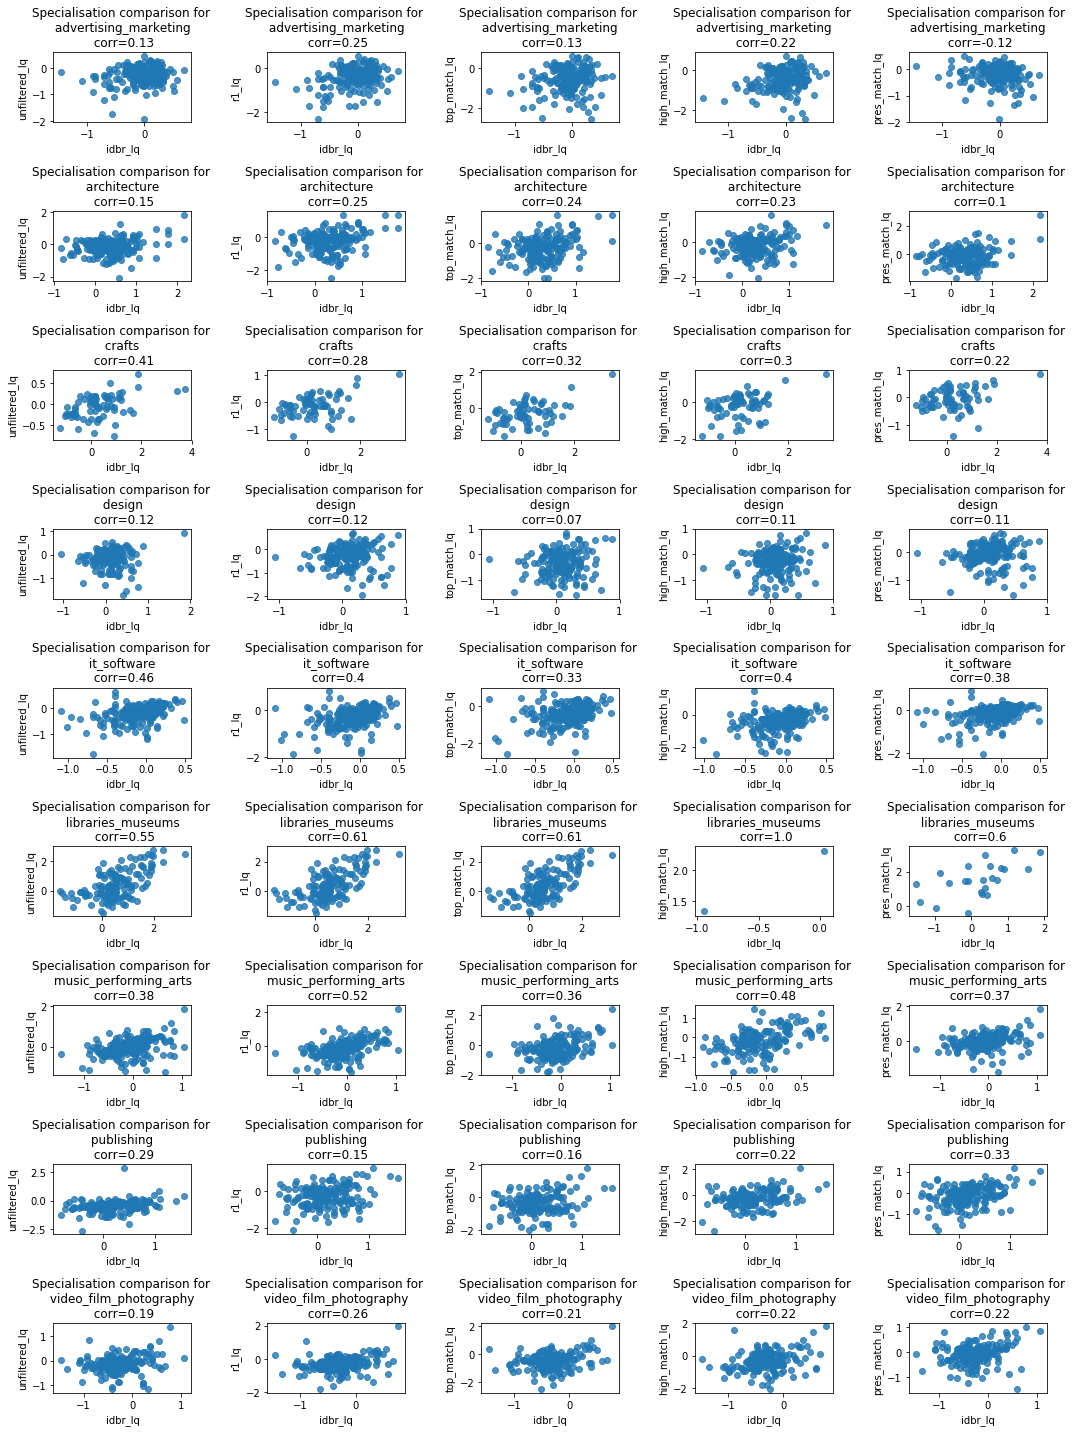

In [524]:
#Let's plot by sector

#Create a bunch of axes
fig,ax = plt.subplots(nrows=len(set(spec_comparison.sector)),ncols=5,
                     figsize=(15,20))

get_validation_charts(spec_comparison,'idbr_lq','unfiltered_lq',ax,col=0)
get_validation_charts(spec_comparison,'idbr_lq','r1_lq',ax,col=1)
get_validation_charts(spec_comparison,'idbr_lq','top_match_lq',ax,col=2)
get_validation_charts(spec_comparison,'idbr_lq','high_match_lq',ax,col=3)
get_validation_charts(spec_comparison,'idbr_lq','pres_match_lq',ax,col=4)

plt.tight_layout()

Filtering affects the quality of the GlassAI match in different ways - although in general it improves it,
with the exception of IT. NB big improvement in advertising, perhaps because the topics are picking up other sectors?

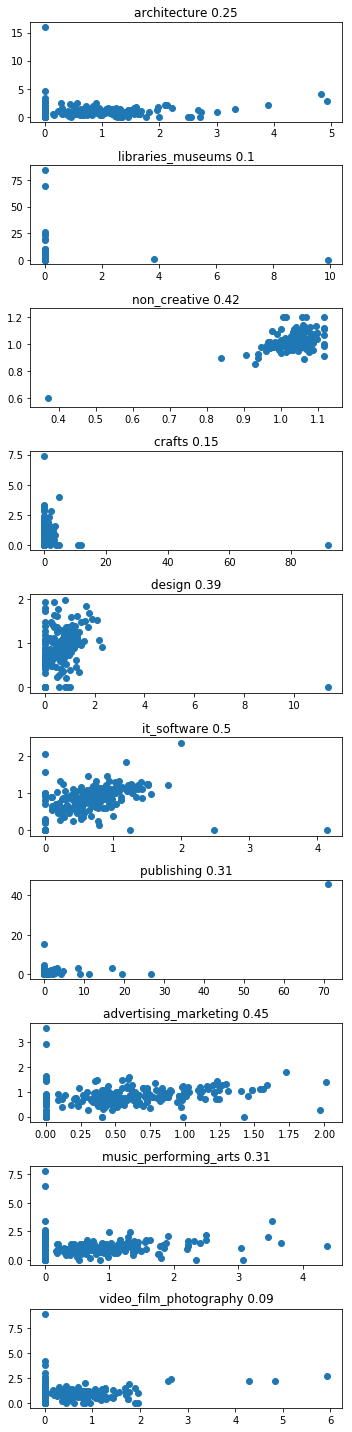

In [525]:
#Visualise correlation between glass AI specialisation and glass AI creative economy specialisation

glai_first_econ_lq = pd.concat([glass_ai_spec_top_thres,glass_ai_spec_pres_thres,
                                idbr_creative_spec.set_index(['ttwa_code','sector_clean'])],axis=1).reset_index(drop=False)

glai_first_econ_lq.rename(columns={'level0':'ttwa_code','level_1':'sector'},inplace=True)

fig,ax = plt.subplots(nrows=len(set(glai_first_econ_lq.sector)),figsize=(5,20))

for num,x in enumerate(set(glai_first_econ_lq.sector)):
    data = glai_first_econ_lq.loc[glai_first_econ_lq.sector==x,:]
    
    #print(data.head())
    corr = data[['high_match_lq','pres_match_lq']].corr('spearman').iloc[0,1]
    #print(corr)
    
    ax[num].scatter(data.high_match_lq,data.pres_match_lq)
    ax[num].set_title(x+" "+str(np.round(corr,2)))
    

plt.tight_layout()



In [526]:
#Interestingly, the best correlation is for Museums, which was identified based on topics. 
#Could we do something similar for other sectors?

#Next steps

#Redo the analysis but classifying businesses into sectors based on their top variable#
#Identify the top labels inside each sector


In [527]:
def get_distinctive_topics(df):
    '''
    This function gets distinctive topics in sectors. We can subset them in different ways 
    
    '''
    
    distinctive_topics_in_sector=[]

    top_keywords_by_sector = df.groupby('dcms_sector')['topics_list'].apply(
        lambda x: pd.Series([t for el in x for t in el]).value_counts(ascending=False)).reset_index(drop=False)

    for x in set(top_keywords_by_sector.dcms_sector):
        print(x)
        print('='*len(x))
    
        topics_in_sector = top_keywords_by_sector.loc[
            top_keywords_by_sector.dcms_sector==x,[
                'level_1','topics_list']].set_index('level_1').sort_values('topics_list',ascending=False)[:50]


        topics_in_sector['share_in_sector'] = topics_in_sector/topics_in_sector.sum()

        topics_in_sector_norm = topics_in_sector.join(all_topics_share)

        topics_in_sector_norm['share_norm'] = topics_in_sector_norm['share_in_sector']/topics_in_sector_norm['share_all']

        print(topics_in_sector_norm.sort_values('share_norm',ascending=False)[:10])
        
        print('\n')

    distinctive_topics_in_sector.append(
        [x,topics_in_sector_norm.sort_values('share_norm',ascending=False)[:50]])
    
    
    return(distinctive_topics_in_sector)
    

Some exploration of topics suggests that R1 / Top match pick up specialist creative businesses, while the rest 
pick up peripheral ('creative economy'?) companies. We can generate counts by sector.

The two tables below show % of 'sector capabilities' in other sectors. 

In [528]:
creative_economy_matrix_r1 = pd.crosstab(glai_labelled.loc[glai_labelled.source!='R1','source_glai_sector'],
                                      glai_labelled.loc[glai_labelled.source!='R1','dcms_sector'],
                                     normalize=0)
100*creative_economy_matrix_r1

dcms_sector,advertising_marketing,architecture,crafts,design,it_software,music_performing_arts,publishing,video_film_photography
source_glai_sector,,,,,,,,
Consumer Goods and Services,19.209040,2.259887,13.135593,26.553672,22.316384,10.310734,3.248588,2.966102
Energy and Environmental,10.380623,17.647059,0.346021,9.688581,54.671280,1.384083,3.114187,2.768166
Financial Services,20.114943,1.436782,3.735632,2.298851,64.080460,2.011494,2.873563,3.448276
Government,33.898305,0.000000,0.000000,3.389831,44.067797,3.389831,10.169492,5.084746
Healthcare and Scientific,22.608696,2.173913,0.869565,9.565217,53.043478,3.478261,4.782609,3.478261
Industrial and Agriculture,22.262774,1.824818,2.919708,25.182482,36.861314,2.737226,3.284672,4.927007
Leisure and Hospitality,30.592105,1.973684,1.809211,10.855263,26.480263,9.046053,5.098684,14.144737
Non Profit and Education,24.618321,0.954198,0.572519,4.389313,38.167939,9.923664,12.404580,8.969466
Professional Services,28.268551,3.798587,0.706714,3.445230,57.950530,1.325088,2.915194,1.590106


In [529]:
creative_economy_matrix_pm = pd.crosstab(glai_labelled.loc[glai_labelled.has_top_subsector==False,'source_glai_sector'],
                                      glai_labelled.loc[glai_labelled.has_top_subsector==False,'dcms_sector'],
                                     normalize=1)
100*creative_economy_matrix_pm

dcms_sector,advertising_marketing,architecture,crafts,design,it_software,music_performing_arts,publishing,video_film_photography
source_glai_sector,,,,,,,,
Consumer Goods and Services,10.3750,3.619048,65.887850,26.219512,5.208333,29.729730,9.854015,7.716049
Energy and Environmental,2.1875,12.761905,0.467290,3.780488,5.153509,1.351351,4.014599,2.469136
Financial Services,5.7500,0.952381,7.009346,1.219512,7.483553,2.702703,4.379562,4.012346
Government,1.3750,0.000000,0.000000,0.243902,0.767544,1.013514,2.554745,0.925926
Healthcare and Scientific,4.0625,0.952381,0.934579,2.804878,3.755482,2.702703,5.474453,3.086420
Industrial and Agriculture,10.0625,1.904762,7.943925,20.000000,6.688596,5.405405,7.299270,10.185185
Leisure and Hospitality,16.4375,2.857143,5.607477,8.902439,5.372807,21.959459,14.233577,32.716049
Non Profit and Education,10.9375,1.714286,1.401869,3.780488,6.441886,19.594595,27.007299,15.123457
Professional Services,26.0000,9.904762,3.738318,6.951220,22.368421,5.405405,15.328467,6.172840


In [530]:
# Create this by TTWA

business_type_location = glai_labelled.groupby(['ttwa_name','ttwa_code'])['has_top_subsector'].value_counts()
business_type_location.name = 'value'
business_type_location = business_type_location.reset_index(drop=False)

business_type_location_long = pd.pivot_table(business_type_location,index=['ttwa_code','ttwa_name'],columns='has_top_subsector',values='value')

business_type_location_long['ci_spec'] = business_type_location_long[True]/business_type_location_long[False]

#data_labelled.groupby('ttwa').apply(lambda x: x.loc[x.source=='R1',:])

#business_type_location_long.loc[top_clusters,:].sort_values('ci_spec',ascending=False)[:30]

The above suggests that many of the more specialised, traditional creative clusters, have a stronger presence
of 'core' creative businesses whereas other areas have more 'periphery' ones. We need additional data from GlassAI to normalise these numbers.

In [531]:
glass_ai_creative_totals = pd.merge(business_type_location_long.reset_index(drop=False),
                          glass_ttwa_totals.drop('sector',axis=1),left_on='ttwa_code',right_on='ttwa_code')

In [532]:
glass_ai_creative_totals.rename(columns={False:'creative_econ',
                                        True:'creative_industries'},inplace=True)

In [533]:
glass_ai_creative_totals['all_firms'] = glass_ai_creative_totals[['creative_econ','creative_industries','business_count']].sum(axis=1)

glass_ai_creative_totals['ci_share'],glass_ai_creative_totals['ce_share'] = [glass_ai_creative_totals[x]/
                                                     glass_ai_creative_totals['all_firms'] for x in ['creative_industries','creative_econ']]

glass_ai_creative_totals['ce_intensity'] = glass_ai_creative_totals['creative_econ']/(
    glass_ai_creative_totals['business_count']+glass_ai_creative_totals['creative_econ'])




## Creative economy analysis

We want a function that, for each TTWA, outputs a df with:

* Share of CE in total by Glass AI sector
* Share of Ce capability in total by Glass AI sector

Do it as a function that loops over ttwa names?


In [534]:
#UK creative economy activity totals
#Focus on R2 matches
national_ce = glai_labelled.loc[[type(x)!=float for x in glai_labelled.creative_sector_not_first=='R2'],:]


national_creative_mix= pd.melt(
    pd.crosstab(national_ce.source_glai_sector,national_ce.creative_sector_not_first).reset_index(drop=False),
    id_vars='source_glai_sector')

#UK non-creative totals

national_non_ce = glass_all.groupby('glass_sector').sum()

#Merge with UK

national_creative_mix = pd.merge(national_creative_mix,national_non_ce.reset_index(drop=False),
                                left_on='source_glai_sector',right_on='glass_sector')

national_creative_mix['share'] = national_creative_mix['value']/(
    national_creative_mix['value']+national_creative_mix['business_count'])

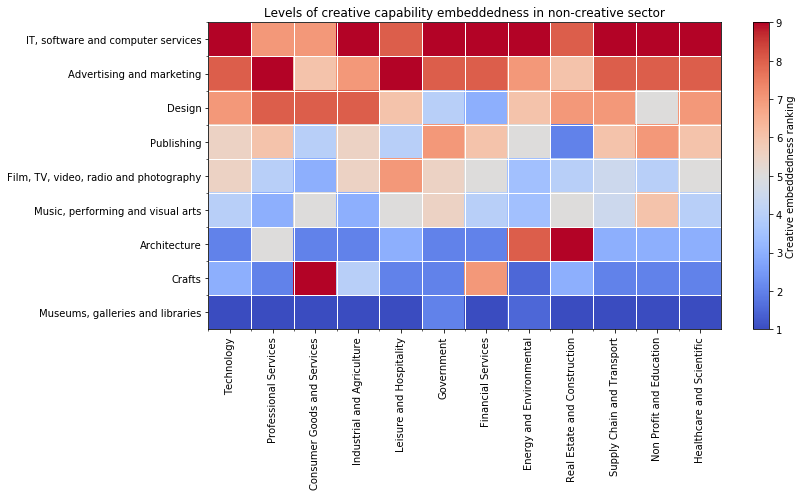

In [535]:
#Mixing matrix (shows share of creative companies in each sector)


national_mix_matrix = pd.pivot_table(national_creative_mix,
                                    index='creative_sector_not_first',columns='glass_sector',values='share')

#Order Y axis and X axis
creative_embeddedness_cr_ranking = national_mix_matrix.rank(axis=0).mean(axis=1).sort_values(ascending=False).index
creative_embeddedness_non_cr_ranking = national_mix_matrix.rank(axis=1).mean().sort_values(ascending=False).index

#Plot
fig,ax = plt.subplots(figsize=(12,7))

#Here we are sorting by the ranking indices above
im = ax.imshow(national_mix_matrix.rank(axis=0).loc[creative_embeddedness_cr_ranking
                                                ,creative_embeddedness_non_cr_ranking],cmap='coolwarm',
              aspect='auto')

#Add ticks
ax.set_yticks(np.arange(len(creative_embeddedness_cr_ranking)))
ax.set_yticklabels({x:y for y,x in dcms_names_lookup.items()}[x] for x in creative_embeddedness_cr_ranking)

ax.set_xticks(np.arange(len(creative_embeddedness_non_cr_ranking)))
ax.set_xticklabels(creative_embeddedness_non_cr_ranking,rotation=90)

#Grid
ax.set_yticks([x -0.5 for x in np.arange(len(creative_embeddedness_cr_ranking))],minor=True)
ax.set_xticks([x-0.5 for x in np.arange(len(creative_embeddedness_non_cr_ranking))],minor=True)
ax.grid(which='minor',color='white',linestyle='-',linewidth=1)

ax.set_title('Levels of creative capability embeddedness in non-creative sector')

fig.colorbar(im,label='Creative embeddedness ranking')

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_creat_embeddedness_sector.pdf'.format(date_today=today_str))

In [536]:
ttwa_code_name_df = glai_labelled[['ttwa_name','ttwa_code']].drop_duplicates().reset_index(drop=True)

ttwa_name_code_lookup =  {x:y for x,y in zip(ttwa_code_name_df.ttwa_name,ttwa_code_name_df.ttwa_code)}

def obtain_creative_econ_stats(ttwa_name):
    '''
    This function extracts creative economy stats for an area (based on its ttwa code)
    '''
    
    ttwa_code = ttwa_name_code_lookup[ttwa_name]
    
    
    #Subset the GlassAI data by the code
    ttwa_set = glai_labelled.loc[(glai_labelled.ttwa_code==ttwa_code) & (glai_labelled.source=='R2'),:]
    
    #Crosstab glai sector vs dcms sector to obtain creative capabilities
    ttwa_caps = pd.melt(pd.crosstab(ttwa_set.source_glai_sector,ttwa_set.dcms_sector).reset_index(drop=False),
                   id_vars='source_glai_sector')
    
    #Create totals of non-creative activity in the area
    ttwa_totals = glass_all.loc[glass_all.ttwa_code==ttwa_code,
                                ['glass_sector','business_count']].groupby(
        'glass_sector')['business_count'].sum().reset_index(drop=False)
    
    #Merge both
    ttwa_united = pd.merge(ttwa_caps,ttwa_totals,left_on='source_glai_sector',right_on='glass_sector')
    
    #Calculate shares of all non-creative businesses with creative capabilities
    ttwa_united['shares'] = ttwa_united['value']/( ttwa_united['value']+ttwa_united['business_count'])
    
    #Create three wide tables
    #One with business counts
    ttwa_united_total = pd.pivot_table(ttwa_united,index='dcms_sector',columns='glass_sector',values='value')
    
    #Complete columns
    for x in creative_embeddedness_non_cr_ranking:
        if x not in ttwa_united_total.columns:
            ttwa_united_total[x]=[0]*len(ttwa_united_total)
            
    for x in creative_embeddedness_cr_ranking:
        if x not in ttwa_united_total.index:
            ttwa_united_total.loc[x,:] = [0]*len(ttwa_united_total.columns)
    
    
    #One with shares of businesses in sector
    ttwa_united_shares = pd.pivot_table(ttwa_united,index='dcms_sector',columns='glass_sector',values='shares')
    #Fill zeroes
    ttwa_united_shares.fillna(value=0,inplace=True)
    
    #This normalises the shares by UK averages
    ttwa_united_normalised = ttwa_united_shares/national_mix_matrix
    
    #Fill zeroes
    ttwa_united_normalised.fillna(0,inplace=True)
    
    #How would we visualise this?
    
    
    
    return([ttwa_united_total,ttwa_united_shares,ttwa_united_normalised])
    #return(ttwa_totals)
                         
def extract_examples(creative,non_creative,place):
    '''
    Returns a dataframe with relevant examples
    
    '''
    
    matches = glai_labelled.loc[
        (glai_labelled.dcms_sector==creative) & 
        (glai_labelled.source_glai_sector==non_creative) & (glai_labelled.ttwa_name==place),:]
    
    return(matches)
    

In [537]:
#Data preparation

#Extract glass sectors
glass_sectors = list(set(glass_all.glass_sector))

#Set colors
set_colors = plt.matplotlib.cm.get_cmap('tab10').colors[:len(set(glai_labelled.dcms_sector.dropna()))]


#Set colors
sector_cols = {sector: color for sector, color in zip(set(glai_labelled.dcms_sector.dropna()),
                                                      set_colors)}

#Sort clusters by number of businesses
glai_labelled_sorted = glai_labelled.loc[glai_labelled.source=='R2',:].reset_index(
    drop=False).groupby('ttwa_name')['index'].count().sort_values(ascending=False).index

#off_stats_sorted = off_stats.loc[off_stats.sector=='creative_industries',:].sort_values('bc_2016',
#                                                                                        ascending=False).reset_index(drop=True)

#my_clusters = list(off_stats_sorted.ttwa_name[off_stats_sorted.is_cluster==True])

creative_clusters = list(off_stats.ttwa_name[off_stats.is_cluster==True])


ce_clusters_sorted = glai_labelled_sorted[[x in creative_clusters for x in glai_labelled_sorted]]

In [538]:
def rescale(vector,vmin,vmax):
    '''
    Rescales a vector with a new minimum and maximum
    
    '''
    vector = vector.dropna()
    
    try:
        rescaled = [((x - min(vector)) / (max(vector) - min(vector) )) * (vmax - vmin) + vmin for x in vector]
    except:
        #The above will fail if the vector is all zeroes (it tries to divide by zero)
        #In that case, we return a vector of zeroes
        
        rescaled = len(vector)*[0]
    
    return(rescaled)


In [539]:
#I need to decide where to normalise - everything?

#In that case I need to extract the data for all TTWAs, combine, melt, rescale and pivot, and
#then extract that by TTWA. It might still not work (London will probably dominate horribly)


#Extract values for all TTWAs and concatenate. NB we add the ttwa name to each output
all_ttwas_counts = pd.concat([pd.concat([
    pd.DataFrame({'ttwa_name':ttwa_name},index=creative_embeddedness_cr_ranking),
    obtain_creative_econ_stats(ttwa_name)[0]],axis=1) 
                   for ttwa_name in ce_clusters_sorted])

#Melt the dataframe
all_ttwas_counts_long = pd.melt(all_ttwas_counts.reset_index(drop=False),id_vars=['ttwa_name','index'])

#Create a variable where the zeroes are nans (we don't want to rescale them to zero)
all_ttwas_counts_long['value_2'] = [0 if x==0 else np.log(x) for x in all_ttwas_counts_long.value] 

#Rescale between 0 and 1
all_ttwas_counts_long['rescaled'] = rescale(all_ttwas_counts_long['value_2'],0,1)

In [540]:
#Order variables for plotting
ce_ttwas_ordered = all_ttwas_counts_long.groupby('ttwa_name')['value'].sum().sort_values(ascending=False).index

non_ce_sectors_ordered = all_ttwas_counts_long.groupby('variable')['value'].sum().sort_values(ascending=False).index

In [541]:
#Now we need to regroup these into area df

ttwas_ce_counts_norm = {x:pd.pivot_table(all_ttwas_counts_long.loc[all_ttwas_counts_long.ttwa_name==x],
                                    index='index',columns='variable',values='rescaled') for x in ce_clusters_sorted}

In [542]:
creative_embeddedness_cr_ranking

Index(['it_software', 'advertising_marketing', 'design', 'publishing',
       'video_film_photography', 'music_performing_arts', 'architecture',
       'crafts', 'libraries_museums'],
      dtype='object', name='creative_sector_not_first')

/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


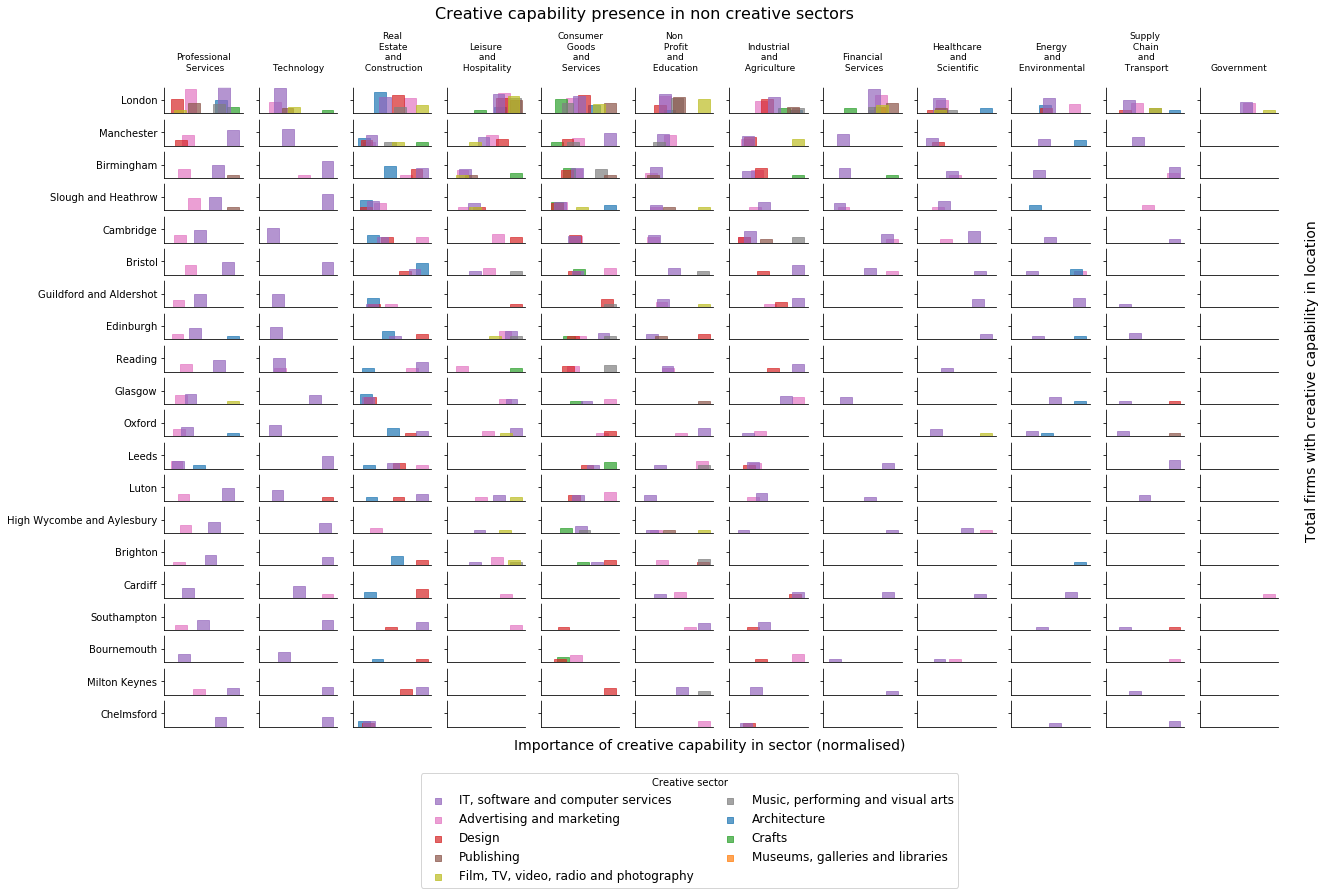

In [543]:
#Create figurtes
fig,ax = plt.subplots(figsize=(18,10),ncols=len(glass_sectors),
                      nrows=len(ce_ttwas_ordered[:20]),
                      sharey='row',
                      sharex='col'
                     )


#We extract the data for each TTWA
for num_clust, ttwa_name in enumerate(ce_ttwas_ordered[:20]):
     
    #Extract the values
    all_values = obtain_creative_econ_stats(ttwa_name)

    #Loop over each sector to create the chart
    for num_sect,sector in enumerate(non_ce_sectors_ordered):
        
        #Extract indices of specialisation
        shares = all_values[2].loc[:,sector]
        
        #Create a vector with colors
        cols =  [sector_cols[ind] for ind in shares.index]
         
        #We extract the counts of creative economy businesses normalised and logged by UK totals 
        totals = ttwas_ce_counts_norm[ttwa_name].loc[:,sector]
        
        
        #Draw the scatter
        ax[num_clust][num_sect].bar(
            x=rescale(shares,0,4),
            height=totals,
            edgecolor=cols,linewidth=0.9,
            alpha=0.7,
            color=cols
        )
        
        #Draw removing ticks and labels
        ax[num_clust][num_sect].set_yticks([])
        ax[num_clust][num_sect].set_xticks([])
        ax[num_clust][num_sect].set_xticklabels([])
        
        #Set x and y limits so everything is in the same scale
        ax[num_clust][num_sect].set_ylim([0,1])
        
        #Change colors of some of the axes to make them invisible
        for pos in ['top','right']:
            ax[num_clust][num_sect].spines[pos].set_color('white')
         
        #Add sector names only for the top plot
        if num_clust==0:
            ax[num_clust][num_sect].set_title(" ".join([x+'\n' for x in sector.split(" ")]),size=9)
            
    #Add yticklabels on the left handside
    ax[num_clust][0].set_yticks([0.5])
    ax[num_clust][0].set_yticklabels([ttwa_name])
    
#Create legend in a hackly way
s1,s2,s3,s4,s5,s6,s7,s8,s9 = [plt.scatter([],[],s=40,marker='s',color=sector_cols[x],alpha=0.7) for x in 
                                       creative_embeddedness_cr_ranking]

#Add legend
plt.legend((s1,s2,s3,s4,s5,s6,s7,s8,s9),
          ({x:y for y,x in dcms_names_lookup.items()}[x] for x in creative_embeddedness_cr_ranking),
           scatterpoints=1,
           title='Creative sector',
           bbox_to_anchor=(-3,-1.5),
           ncol=2,
           fontsize=12)

#Add figure title
fig.suptitle('Creative capability presence in non creative sectors',y=1.02,size=16)

#Add another ax for the x labels
ax_final = fig.add_axes([0.5,-0.12,0.1,0.1])

ax_final.axis('off')
ax_final.set_title('Importance of creative capability in sector (normalised)',size=14)

#Add another ax for the y labels
ax_final_2 = fig.add_axes([1,0.6,0.03,0.1])

ax_final_2.axis('off')
ax_final_2.set_title('Total firms with creative capability in location',size=14,rotation=90)

#Final adjustments and saving
plt.tight_layout()
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig(fig_path+'/{today}_creative_econ.pdf'.format(today=today_str),bbox_inches='tight')


In [544]:
#Final analysis - is there any correlation between an area's specialisation in a creative sector and its 
# creative economy diffusion

ttwa_code_name_lookup = {y:x for x,y in ttwa_name_code_lookup.items()}



#Measuring diffusion: Creative LQ?

idbr_lqs = pd.read_csv(ext_data+'/29_11_2017_idbr_lqs_benchmarking.csv')


#Embedded totals
embedded_totals = glai_labelled.groupby(['source','ttwa_name','dcms_sector','ttwa_code'])['index'].count().reset_index(drop=False)

#Create two variable names (embeddded and specialist)
embedded_totals['sector'] = [y+'_glai_embedded' if x=='R2' else y+'_glai_spec' for x,y in zip(embedded_totals.source,
                                                                                embedded_totals.dcms_sector)]


#What do we want to do with this?
#Create an LQ for every variable?

#Create a creative embeddedness index by sector (% of creative businesses which are embedded)
embedded_short = embedded_totals[['ttwa_name','sector','index']]

embedded_short.rename(columns={'index':'business_count'},inplace=True)

#Concatenate with glass AI totals to do LQs
glass_ttwa_totals['ttwa_name'] = [ttwa_code_name_lookup[x] for x in glass_ttwa_totals['ttwa_code']]

#Here
embedded_totals = pd.concat([embedded_short,glass_ttwa_totals.drop('ttwa_code',axis=1)])

#all_glass_sectors_lq = create_lq_df(pd.pivot_table(embedded_totals,
#                                                  index='ttwa_name',columns='dcms_sector',))

#Create 2016 LQs dataframe (for creative sectors)
idbr_lqs_2016 = idbr_lqs.loc[idbr_lqs['year']==2016,:].drop('year',axis=1).set_index('ttwa_name')
idbr_lqs_2016.columns = [dcms_names_lookup[x]+'_official' for x in idbr_lqs_2016.columns]

combined_lq_df = pd.concat([create_lq_df(pd.pivot_table(embedded_totals,index='ttwa_name',columns='sector',
                                           values='business_count')),idbr_lqs_2016],axis=1)



#Merge with TTWA totals to normalsise
#embedded_totals = pd.merge(embedded_totals,glass_ttwa_totals,left_on='ttwa_code',right_on='ttwa_code')

#Calculate them as...
#Share of total firms in the location
#embedded_totals_lqs = pd.concat([create_lq_df(pd.pivot_table(embedded_totals,
#                                                            index='ttwa_name',columns='dcms_sector'))])
#Share of 



/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [545]:
combined_lq_df

,advertising_marketing_glai_embedded,advertising_marketing_glai_spec,architecture_glai_embedded,architecture_glai_spec,crafts_glai_embedded,crafts_glai_spec,design_glai_embedded,design_glai_spec,it_software_glai_embedded,it_software_glai_spec,...,advertising_marketing_official,architecture_official,crafts_official,design_official,video_film_photography_official,it_software_official,libraries_museums_official,music_performing_arts_official,publishing_official,not_in_sector_official
(pseudo) Channel Islands,0.321412,1.528092,1.677098,2.010959,0.491447,2.058257,0.360509,0.415458,0.904671,0.861973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(pseudo) Isle of Man,1.019864,0.510395,1.064312,1.276186,2.495036,NaN,0.915139,0.175771,1.476304,1.148745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aberdeen,1.279829,0.656508,0.500853,0.800744,0.978446,0.512236,1.112522,0.716868,1.235078,1.098333,...,0.339683,1.274718,0.000000,0.558246,0.313504,0.512765,1.554661,0.269529,0.361641,1.053788
Aberystwyth,0.597554,0.448573,1.558993,0.934671,4.568376,2.869964,NaN,0.514933,0.720825,0.560890,...,0.275406,0.555649,0.000000,0.198514,0.273313,0.224549,1.658524,0.520302,1.628940,1.068736
Alness and Invergordon,NaN,NaN,NaN,4.147603,NaN,8.490310,NaN,NaN,NaN,NaN,...,0.622082,0.941319,0.000000,0.000000,0.000000,0.217375,0.000000,0.000000,0.000000,1.084612
Andover,0.909135,0.909962,0.790632,0.158004,1.235637,0.323440,0.793121,1.479820,0.812358,0.785627,...,0.726260,0.439583,0.000000,1.256380,0.432445,1.154689,0.000000,0.926144,0.644341,1.007016
Arbroath and Montrose,2.164608,0.433315,1.129474,NaN,NaN,NaN,NaN,0.373064,1.740767,0.580513,...,0.000000,1.162454,0.000000,0.415303,0.285894,0.268441,0.000000,0.272126,0.851961,1.072230
Ashford,1.301421,1.074648,1.018606,1.017817,0.994953,1.250107,1.021812,0.897184,1.334410,0.540981,...,1.026963,0.988893,0.900814,1.009418,0.625393,0.799263,0.000000,0.694489,0.724759,1.021512
Aviemore and Grantown-on-Spey,7.071054,NaN,NaN,NaN,NaN,NaN,2.643735,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.610553,0.143320,2.469983,0.000000,0.000000,1.088616
Ayr,0.358532,0.986860,NaN,0.841204,1.644615,0.573993,1.005364,0.463440,1.369567,0.480762,...,0.489116,0.555088,0.000000,0.330522,0.182024,0.384552,2.209131,0.563091,0.271216,1.062620


[Text(0,0,'advertising_marketing_glai_embedded'),
 Text(0,0,'advertising_marketing_glai_spec'),
 Text(0,0,'advertising_marketing_official'),
 Text(0,0,'architecture_glai_embedded'),
 Text(0,0,'architecture_glai_spec'),
 Text(0,0,'architecture_official'),
 Text(0,0,'crafts_glai_embedded'),
 Text(0,0,'crafts_glai_spec'),
 Text(0,0,'crafts_official'),
 Text(0,0,'design_glai_embedded'),
 Text(0,0,'design_glai_spec'),
 Text(0,0,'design_official'),
 Text(0,0,'it_software_glai_embedded'),
 Text(0,0,'it_software_glai_spec'),
 Text(0,0,'it_software_official'),
 Text(0,0,'libraries_museums_glai_embedded'),
 Text(0,0,'libraries_museums_glai_spec'),
 Text(0,0,'libraries_museums_official'),
 Text(0,0,'music_performing_arts_glai_embedded'),
 Text(0,0,'music_performing_arts_glai_spec'),
 Text(0,0,'music_performing_arts_official'),
 Text(0,0,'non_creative'),
 Text(0,0,'not_in_sector_official'),
 Text(0,0,'publishing_glai_embedded'),
 Text(0,0,'publishing_glai_spec'),
 Text(0,0,'publishing_official'),


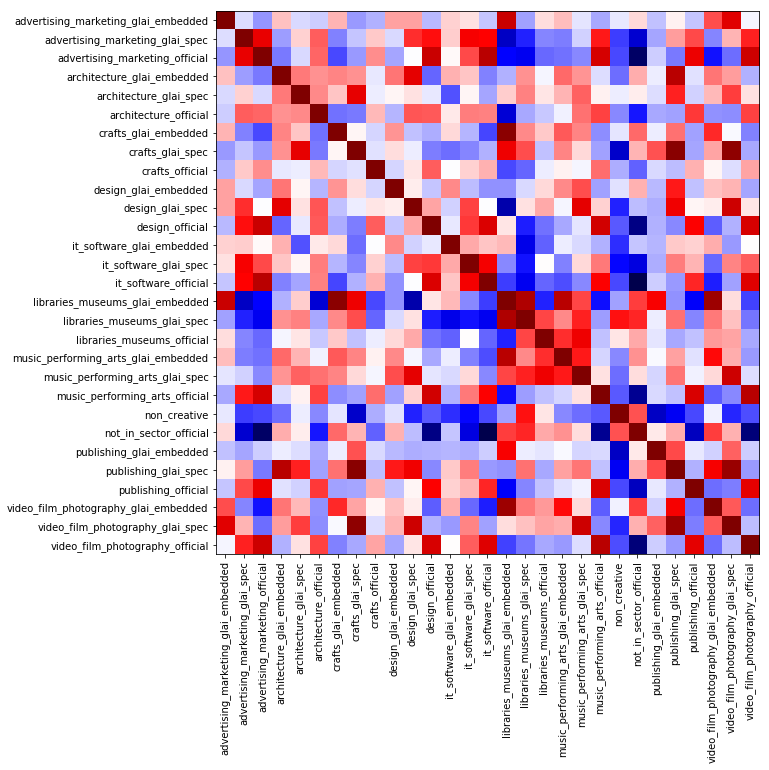

In [546]:
fig,ax = plt.subplots(figsize=(10,10))

lq_correlations = combined_lq_df.corr()

lq_correlations.columns = [x.lower() for x in lq_correlations.columns]
lq_correlations.index = [x.lower() for x in lq_correlations.index]

ax.imshow(lq_correlations.loc[sorted(lq_correlations.columns),
                              sorted(lq_correlations.columns)],cmap='seismic')

ax.set_xticks(np.arange(0,len(lq_correlations)))
ax.set_xticklabels(sorted(lq_correlations.columns),rotation=90)

ax.set_yticks(np.arange(0,len(lq_correlations)))
ax.set_yticklabels(sorted(lq_correlations.columns))



In [55]:
out = extract_examples(creative='video_film_photography',non_creative='Industrial and Agriculture',place='Bath')

In [133]:
#pd.Series(
#    [x for el in glai_labelled.loc[glai_labelled.ttwa_name=='Cardiff','long_topics'] for x in el]).value_counts()

south wales                 12
long term                    9
high quality                 9
web design                   6
social media                 6
news item                    5
web technology               5
service value                5
exceeds expectations         5
sports industry              5
content creation             4
young person                 4
client base                  4
search engine                4
business intelligence        4
large scale                  4
interior design              4
welsh business               4
online presence              4
key communication            4
public relation              4
dedicated content            4
creative design              4
customer service             4
welsh language               4
bespoke jewellery            4
team member                  3
architectural practice       3
high end                     3
web development              3
                            ..
government organisations     1
mission 

In [131]:
 glai_labelled.columns

Index(['index', 'name', 'creative_glai_sector', 'creative_glai_subsector',
       'source', 'source_glai_sector', 'source_glai_subsector',
       'sector_probabilities', 'website', 'topics_list', 'description_1',
       'description2', 'long_topics', 'postcode_list', 'postcode_top', 'pcds',
       'laua', 'gor', 'ttwa', 'ttwa_code', 'ttwa_name', 'sector', 'subsector',
       'dcms_sector', 'has_top_subsector'],
      dtype='object')